# snATAC-seq - Visualisation of genomic regions with nuclei as variables

Blanca Pijuan-Sala

17 April 2019

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
import pandas as pd
import matplotlib.pyplot as plt
import episcanpy.api as epi
import anndata as ad
import numpy as np

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
#Set working directory
wd = '/path/to/directory/sample_pooled_preprocess_revision1/'
direc = wd
sc.settings.figdir = './plots/'
results_file="./write/20190416_snATACseq_embryo_revision01_doublets_cisTopic_50_100_filtered_cellsAsVars_TFIDF_obsCells.h5ad"

/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.0 scipy==1.3.0 pandas==0.24.0 scikit-learn==0.20.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# colour Palettes

In [30]:
##====== Create colour palette for gene expression profiles ======##

from matplotlib.colors import LinearSegmentedColormap
rmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=['lightgrey', 'thistle', 'red', 'darkred'])

cmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#BFBFBF","#6495ED","#000000"])

# Read files

In [2]:
##====== Read counts ======##

filename_data = direc + '11_matrix_afterClusterQC/embryo_revision1_allPeaks_afterClusterPeak.mat.bin.mtx'
filename_gene_names = direc + '11_matrix_afterClusterQC/embryo_revision1_allPeaks_passedQC_peakNames.txt'
filename_barcodes = direc + '11_matrix_afterClusterQC/embryo_revision1_allPeaks_passedQC_barcodeNames.xgi'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
#adata_all_cells = epi.tl.read_ATAC(filename_data, filename_barcodes, filename_gene_names,path_file='')

print('reading counts')
adata_all_cells = sc.read(filename_data, cache=True).transpose()
adata_all_cells.X = adata_all_cells.X.astype(np.int64)
print('reading genes')
adata_all_cells.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adata_all_cells.obs_names = np.genfromtxt(filename_barcodes, dtype='str')



reading counts
Only considering the two last: ['.bin', '.mtx'].
Only considering the two last: ['.bin', '.mtx'].
... reading from cache file cache/home-USSR-codex-pipeline-Data-Rebecca-Blanca-sample_pooled_preprocess_revision1-11_matrix_afterClusterQC-embryo_revision1_allPeaks_afterClusterPeak.mat.bin.h5ad
reading genes
reading cells


In [3]:
adata_all_cells.shape

(23838, 305187)

In [20]:
#Filter for cells that have passed QC
cells = np.genfromtxt(direc + "12_barcodeStats_celltypePeaks/embryo_revision1_readsPeaks24.xgi", dtype='str')
adata_t = adata_all_cells[np.array([str(i) in cells for i in adata_all_cells.obs_names]),:]


In [21]:
adata_t.shape

(19453, 305187)

# Study accessibility landscape

In [24]:
#Transpose the data
adata_t_temp = sc.AnnData(adata_t.X.transpose())
adata_t_temp.var_names = adata_t.obs_names
adata_t_temp.obs_names = adata_t.var_names

In [25]:
adata_t_temp.shape

(305187, 19453)

In [28]:
#Calculate accessibility

adata_t_temp.obs['accessibility'] = np.sum(adata_t_temp.X,axis=1)

In [29]:
#Write down accessibility
accessibility_score = pd.DataFrame(data=adata_t_temp.obs['accessibility']  )
accessibility_score.to_csv(direc + '14_visualisation/data/snATACseq_embryo_revision1_cellsAsVars_TFIDF_with_cellsObs_accessibility.csv', sep=',')


# TF-IDF transformation

1- TF-IDF transformation with nuclei as observations.

In [31]:
#https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True)
tfidf = transformer.fit_transform(adata_t.X)


In [33]:
#https://icb-anndata.readthedocs-hosted.com/en/latest/anndata.AnnData.html
adata = sc.AnnData(tfidf)
adata.var_names = list(adata_t.var_names)
adata.obs_names = list(adata_t.obs_names)


In [34]:
adata.shape


(19453, 305187)

2- Transpose data so that nuclei are the variables

In [35]:
adataT =adata

In [36]:

adata = sc.AnnData(adataT.X.transpose())
adata.var_names = adataT.obs_names
adata.obs_names = adataT.var_names

In [42]:
adata.shape

(305187, 19453)

# Visualise after filtering

In [37]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:05:40)


In [38]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:09:11)


In [39]:
sc.tl.umap(adata,random_state=3,min_dist=0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:17:39)


In [40]:
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures

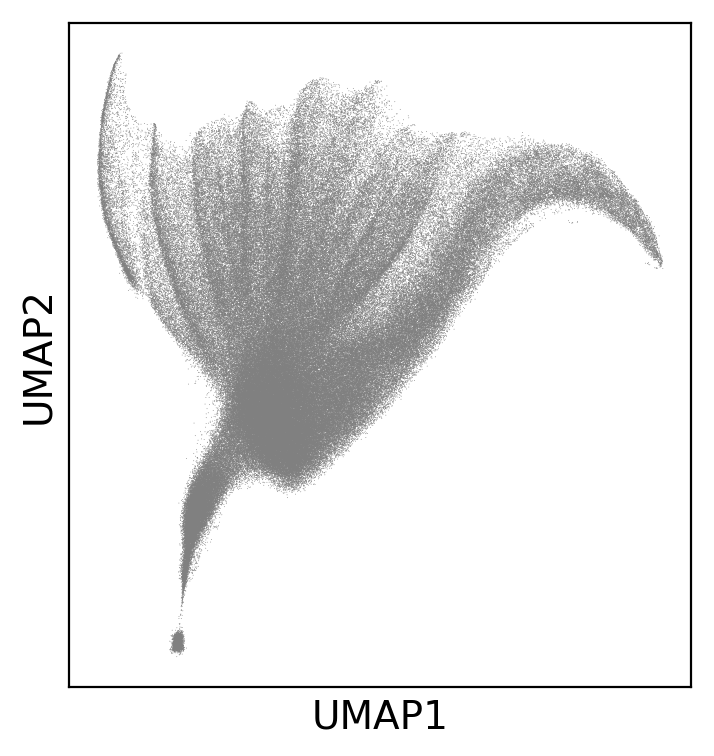

In [41]:
sc.pl.scatter(adata,basis="umap")

In [15]:
#sc.write(results_file,adata)

In [10]:
#adata= sc.read(results_file)

# Write files

In [ ]:
#adata = sc.read(results_file)

In [43]:
#save PCA
PCA = pd.DataFrame(data=adata.obsm['X_pca'])
PCA.to_csv(direc + '14_visualisation/data/snATACseq_embryo_revision1_cellsAsVars_TFIDF_with_cellsObs_PCA.csv', sep=',')
#save UMAP
UMAP = pd.DataFrame(data=adata.obsm['X_umap'])
UMAP.to_csv(direc + '14_visualisation/data/snATACseq_embryo_revision1_cellsAsVars_TFIDF_with_cellsObs_UMAP.csv', sep=',')

#save peaks used
Peaks = pd.DataFrame(data=adata.obs_names)
Peaks.to_csv(direc + '14_visualisation/data/snATACseq_embryo_revision1_cellsAsVars_TFIDF_with_cellsObs_peakLabels.csv', sep=',')